In [1]:
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import torch
from src.data.datasets import DataModule


import numpy as np
from sklearn import datasets
from evidently.report import Report
from evidently.metrics import DataDriftTable
from evidently.metrics import DatasetDriftMetric

/home/javier/anaconda3/envs/tsl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/javier/anaconda3/envs/tsl/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/javier/anaconda3/envs/tsl/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be cha

In [2]:
def load_tensors(file_name):
    with open(file_name, 'rb') as f:
        outputs = pickle.load(f)
        
    for i in range(len(outputs)):
        if i == 0:
            x_real = outputs[i]['x_real']
            x_fake = outputs[i]['x_fake']
            d_pred = outputs[i]['d_pred']
            imputation = outputs[i]['imputation']
            input_mask_int = outputs[i]['input_mask_int']
            input_mask_bool = outputs[i]['input_mask_bool']
            known_values = outputs[i]['known_values']
        else:
            x_real = torch.cat([x_real, outputs[i]['x_real']], dim=0)
            x_fake = torch.cat([x_fake, outputs[i]['x_fake']], dim=0)
            d_pred = torch.cat([d_pred, outputs[i]['d_pred']], dim=0)
            imputation = torch.cat([imputation, outputs[i]['imputation']], dim=0)
            input_mask_int = torch.cat([input_mask_int, outputs[i]['input_mask_int']], dim=0)
            input_mask_bool = torch.cat([input_mask_bool, outputs[i]['input_mask_bool']], dim=0)
            known_values = torch.cat([known_values, outputs[i]['known_values']], dim=0)
            
    return x_real, x_fake, d_pred, imputation, input_mask_int, input_mask_bool, known_values
        
    
def prepare_data(x_real, x_fake, imputation, input_mask_bool):
    x1 = x_real[~input_mask_bool].flatten().cpu().detach().numpy()
    x2 = x_fake[~input_mask_bool].flatten().cpu().detach().numpy()
    
    df1 = pd.DataFrame({'x': x1, 'type': ['real' for _ in range(len(x1))]})
    df2 = pd.DataFrame({'x': x2, 'type': ['G' for _ in range(len(x2))]})
    
    diff = imputation[~input_mask_bool].flatten().cpu().detach().numpy() - x_real[~input_mask_bool].flatten().cpu().detach().numpy()
    return pd.concat([df1, df2]), diff

def plot_figures(df, diff, d_pred, input_mask_bool):
    plt.figure()
    sns.histplot(data=df, x='x', hue='type', stat='density', common_norm=False)
    plt.title('Histograma de valores reales y generados por G')
    plt.xlabel('Valor generado')
    plt.show()
    
    plt.figure()
    plt.title("Histograma de errores cometidos por G (y'-y)")
    plt.xlabel('Error cometido')
    sns.histplot(data=diff, stat='density')
    plt.show()
    
    plt.figure()
    sns.histplot(data=d_pred.flatten().cpu().detach().numpy(), stat='density')
    plt.title('Histograma de predicciones de D (todos)')
    plt.show()
    
    plt.figure()
    sns.histplot(data=d_pred[input_mask_bool].flatten().cpu().detach().numpy(), stat='density')
    plt.title('Histograma de predicciones de D (reales)')
    plt.show()
    
    plt.figure()
    sns.histplot(data=d_pred[~input_mask_bool].flatten().cpu().detach().numpy(), stat='density')
    plt.title('Histograma de predicciones de D (falsos)')
    plt.show()

def get_report(train, test):

    data_drift_dataset_report = Report(metrics=[

    DatasetDriftMetric(),

    DataDriftTable(),    

    ])

    df_train_x = pd.DataFrame(train)
    df_test_x = pd.DataFrame(test)

    df_train_x.columns = ['x']
    df_test_x.columns = ['x']

    data_drift_dataset_report.run(
    reference_data=df_train_x,
    current_data=df_test_x,
    )

    print(data_drift_dataset_report.json())

def get_values(dataloader):
    list = []
    for batch in dataloader:
        x, x_real, input_mask_bool, input_mask_int, known_values, time_gap_matrix = batch
        list.append(x_real)
        
    for i in range(len(list)):
        if i == 0:
            x_real_flatten = list[i]
        else:
            x_real_flatten = torch.cat([x_real, list[i]], dim=0)
            
    return x_real_flatten.flatten().cpu().detach().numpy()

def plot_results(train, test):
    df1 = pd.DataFrame({'x': train, 'type': ['train' for _ in range(len(train))]})
    df2 = pd.DataFrame({'x': test, 'type': ['test' for _ in range(len(test))]})

    df = pd.concat([df1, df2], axis=0)

    plt.figure()
    sns.histplot(data=df, x='x', hue='type', stat='density', common_norm=False)
    plt.title('Histograma de los valores de train y de test')
    plt.xlabel('Valores reales')
    plt.show()

    get_report(train, test)
    
    

# Análisis de resultados con H=0.9

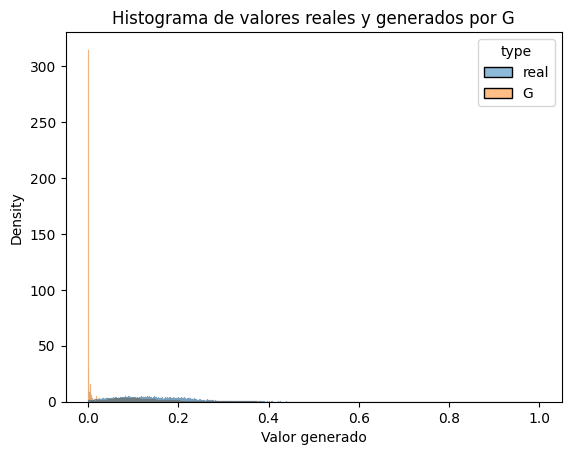

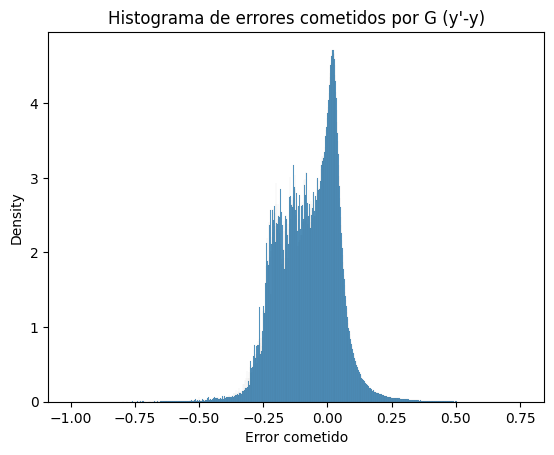

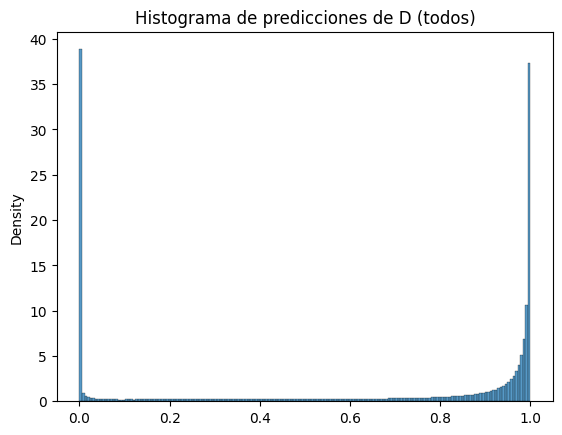

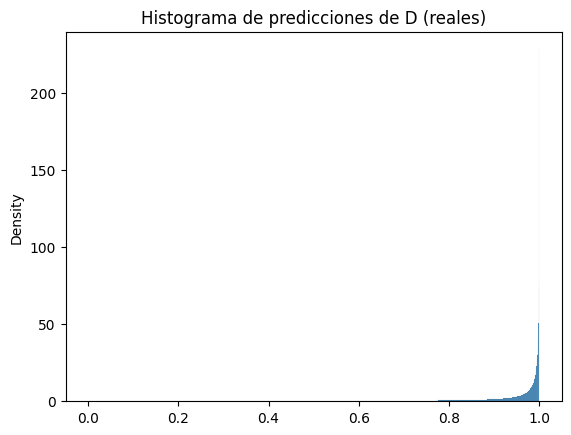

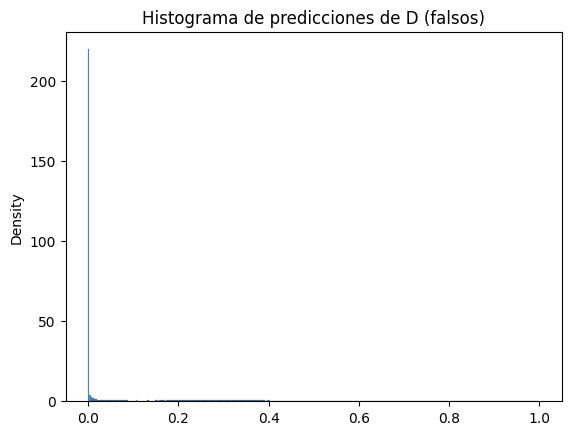

In [3]:
x_real, x_fake, d_pred, imputation, input_mask_int, input_mask_bool, known_values = load_tensors('outputs_test_h_0.9.pkl')
df_9, diff_9 = prepare_data(x_real, x_fake, imputation, input_mask_bool)
plot_figures(df_9, diff_9, d_pred, input_mask_bool)

# Análisis de resultados con H=0.1

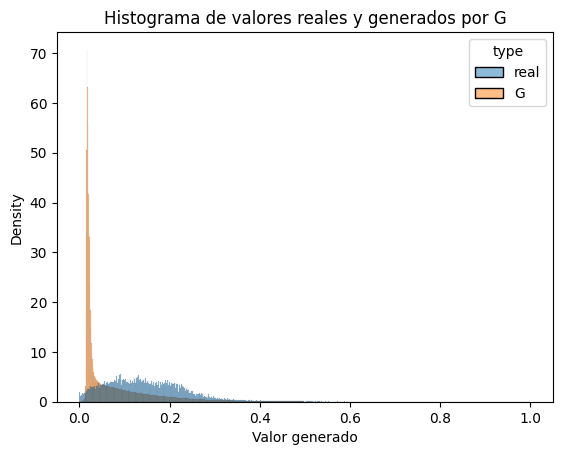

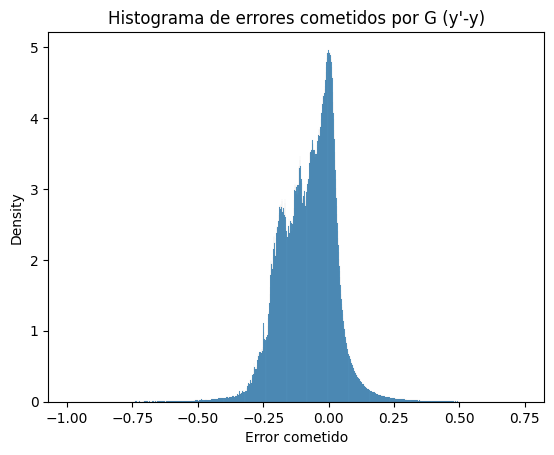

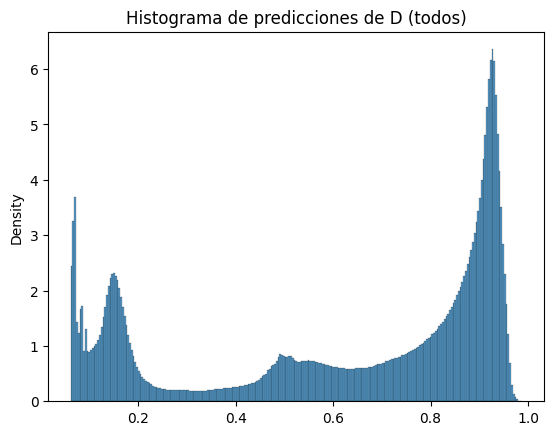

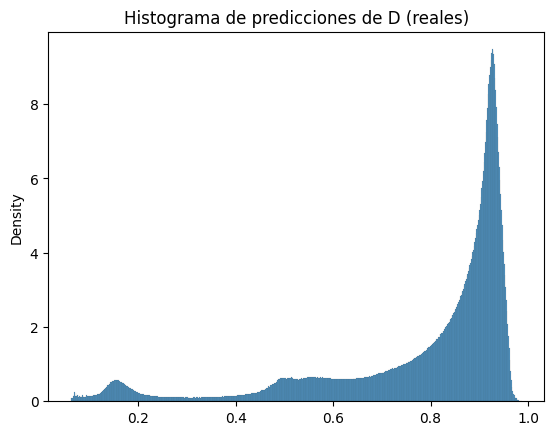

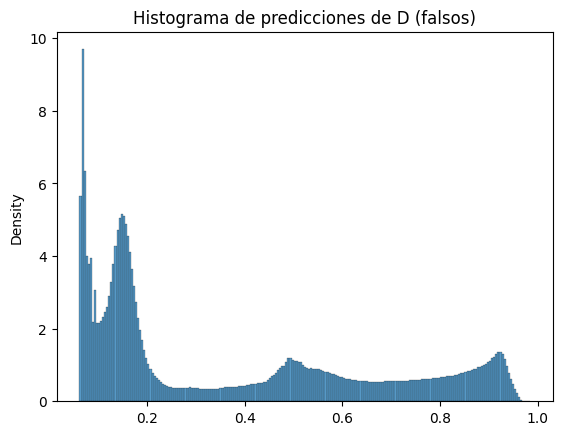

In [11]:
x_real, x_fake, d_pred, imputation, input_mask_int, input_mask_bool, known_values = load_tensors('outputs_test_h_0.1.pkl')
df_1, diff_1 = prepare_data(x_real, x_fake, imputation, input_mask_bool)
plot_figures(df_1, diff_1, d_pred, input_mask_bool)

# Análisis de las distribuciones de los datos

Missing percentaje: 35.46


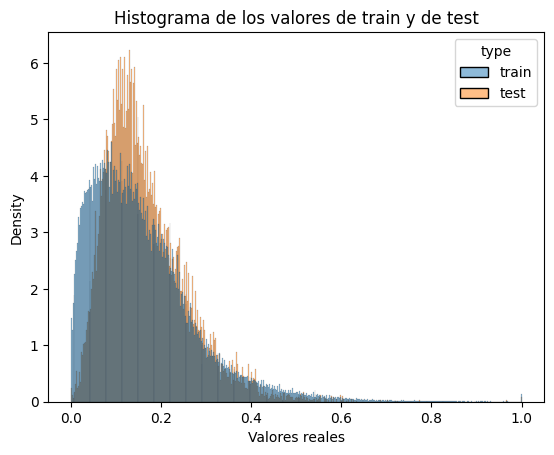

{"version": "0.4.0", "metrics": [{"metric": "DatasetDriftMetric", "result": {"drift_share": 0.5, "number_of_columns": 1, "number_of_drifted_columns": 1, "share_of_drifted_columns": 1.0, "dataset_drift": true}}, {"metric": "DataDriftTable", "result": {"number_of_columns": 1, "number_of_drifted_columns": 1, "share_of_drifted_columns": 1.0, "dataset_drift": true, "drift_by_columns": {"x": {"column_name": "x", "column_type": "num", "stattest_name": "Wasserstein distance (normed)", "stattest_threshold": 0.1, "drift_score": 0.17262301005905434, "drift_detected": true, "current": {"small_distribution": {"x": [0.0, 0.10000000894069672, 0.20000001788139343, 0.30000004172325134, 0.40000003576278687, 0.5000000596046448, 0.6000000834465027, 0.7000001072883606, 0.8000000715255737, 0.9000000953674316, 1.0000001192092896], "y": [2.41056423909356, 4.642781812210358, 2.1050719618798497, 0.6223303193210851, 0.1572749434333188, 0.05034323742515449, 0.0069126604419009465, 0.002097636143003044, 0.0, 0.0026

In [5]:
dm = DataModule(dataset='air_out')
dm.setup()

train_loader = dm.train_dataloader()
test_loader = dm.test_dataloader()

train_x = get_values(train_loader)
test_x = get_values(test_loader)

plot_results(train_x, test_x)

Missing percentaje: 36.31


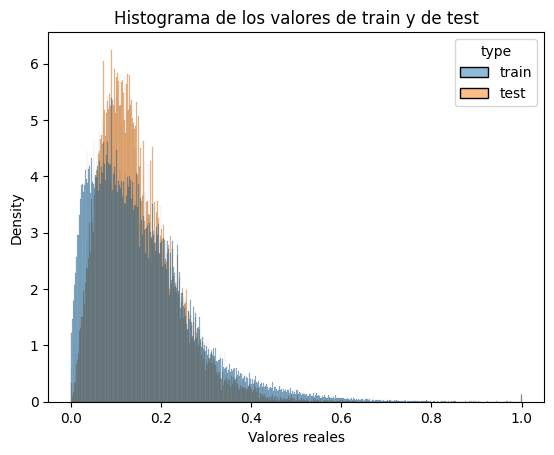

{"version": "0.4.0", "metrics": [{"metric": "DatasetDriftMetric", "result": {"drift_share": 0.5, "number_of_columns": 1, "number_of_drifted_columns": 1, "share_of_drifted_columns": 1.0, "dataset_drift": true}}, {"metric": "DataDriftTable", "result": {"number_of_columns": 1, "number_of_drifted_columns": 1, "share_of_drifted_columns": 1.0, "dataset_drift": true, "drift_by_columns": {"x": {"column_name": "x", "column_type": "num", "stattest_name": "Wasserstein distance (normed)", "stattest_threshold": 0.1, "drift_score": 0.18260618663425526, "drift_detected": true, "current": {"small_distribution": {"x": [0.0, 0.10000000894069672, 0.20000001788139343, 0.30000004172325134, 0.40000003576278687, 0.5000000596046448, 0.6000000834465027, 0.7000001072883606, 0.8000000715255737, 0.9000000953674316, 1.0000001192092896], "y": [3.248193223264388, 4.418637912668822, 1.763366897331469, 0.4384688204030577, 0.09836068811049697, 0.023589879414418136, 0.004580063199190529, 0.002358138034138974, 0.00020431

In [6]:
dm = DataModule(dataset='air_in')
dm.setup()

train_loader = dm.train_dataloader()
test_loader = dm.test_dataloader()

train_x = get_values(train_loader)
test_x = get_values(test_loader)

plot_results(train_x, test_x)

# Análisis datadrif en la

download: 14.5MB [00:01, 10.2MB/s]                            


Missing percentaje: 31.16


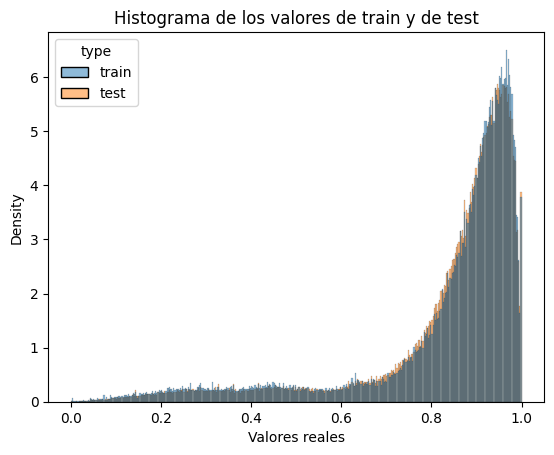

{"version": "0.4.0", "metrics": [{"metric": "DatasetDriftMetric", "result": {"drift_share": 0.5, "number_of_columns": 1, "number_of_drifted_columns": 0, "share_of_drifted_columns": 0.0, "dataset_drift": false}}, {"metric": "DataDriftTable", "result": {"number_of_columns": 1, "number_of_drifted_columns": 0, "share_of_drifted_columns": 0.0, "dataset_drift": false, "drift_by_columns": {"x": {"column_name": "x", "column_type": "num", "stattest_name": "Wasserstein distance (normed)", "stattest_threshold": 0.1, "drift_score": 0.03988559840995721, "drift_detected": false, "current": {"small_distribution": {"x": [0.0, 0.10000000894069672, 0.20000001788139343, 0.30000004172325134, 0.40000003576278687, 0.5000000596046448, 0.6000000834465027, 0.7000001072883606, 0.8000000715255737, 0.9000000953674316, 1.0000001192092896], "y": [0.03029699083341301, 0.11766023152428202, 0.20379911139523244, 0.21461063417067733, 0.2547229500434251, 0.2238034229098444, 0.370743806556076, 0.9050088732189556, 2.739117

In [3]:
dm = DataModule(dataset='la_point')
dm.setup()

train_loader = dm.train_dataloader()
test_loader = dm.test_dataloader()

train_x = get_values(train_loader)
test_x = get_values(test_loader)

plot_results(train_x, test_x)

# Análisis Bay

download: 29.6MB [00:04, 7.06MB/s]                            


Missing percentaje: 25.03


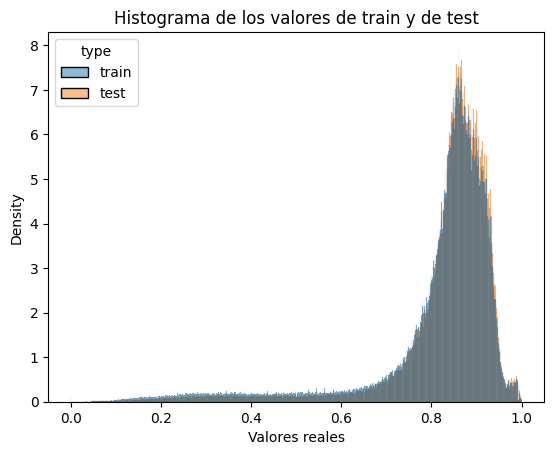

{"version": "0.4.0", "metrics": [{"metric": "DatasetDriftMetric", "result": {"drift_share": 0.5, "number_of_columns": 1, "number_of_drifted_columns": 1, "share_of_drifted_columns": 1.0, "dataset_drift": true}}, {"metric": "DataDriftTable", "result": {"number_of_columns": 1, "number_of_drifted_columns": 1, "share_of_drifted_columns": 1.0, "dataset_drift": true, "drift_by_columns": {"x": {"column_name": "x", "column_type": "num", "stattest_name": "Wasserstein distance (normed)", "stattest_threshold": 0.1, "drift_score": 0.11616563452922206, "drift_detected": true, "current": {"small_distribution": {"x": [0.0, 0.10000000149011612, 0.20000000298023224, 0.30000001192092896, 0.4000000059604645, 0.5, 0.6000000238418579, 0.699999988079071, 0.800000011920929, 0.8999999761581421, 1.0], "y": [0.009791490414816754, 0.04258946118559863, 0.10190193509889356, 0.12986757606981755, 0.12813469346441642, 0.14543529922239495, 0.28336161162259643, 1.204395317245384, 5.585941699012741, 2.368582134637943]}},

In [4]:
dm = DataModule(dataset='bay_point')
dm.setup()

train_loader = dm.train_dataloader()
test_loader = dm.test_dataloader()

train_x = get_values(train_loader)
test_x = get_values(test_loader)

plot_results(train_x, test_x)

# Análisis electric

0.25
Missing percentaje: 25.06


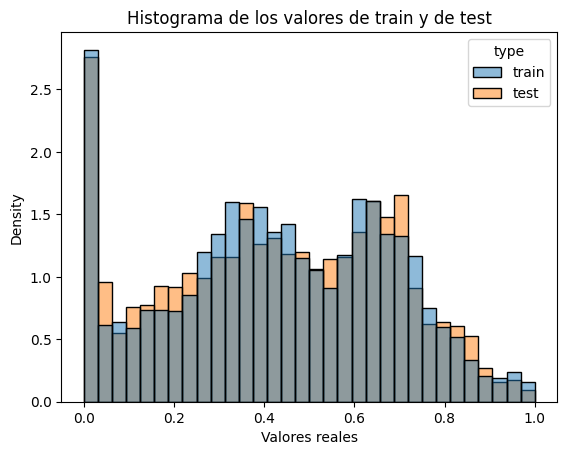

{"version": "0.4.0", "metrics": [{"metric": "DatasetDriftMetric", "result": {"drift_share": 0.5, "number_of_columns": 1, "number_of_drifted_columns": 0, "share_of_drifted_columns": 0.0, "dataset_drift": false}}, {"metric": "DataDriftTable", "result": {"number_of_columns": 1, "number_of_drifted_columns": 0, "share_of_drifted_columns": 0.0, "dataset_drift": false, "drift_by_columns": {"x": {"column_name": "x", "column_type": "num", "stattest_name": "Wasserstein distance (normed)", "stattest_threshold": 0.1, "drift_score": 0.03270042326444815, "drift_detected": false, "current": {"small_distribution": {"x": [0.0, 0.09999999403953552, 0.19999998807907104, 0.29999998211860657, 0.3999999761581421, 0.4999999701976776, 0.5999999642372131, 0.6999999284744263, 0.7999999523162842, 0.8999999761581421, 0.9999999403953552], "y": [1.3837449384447038, 0.8024691836333597, 1.0673868948969367, 1.2988683901757907, 1.237139991434763, 1.1213992437953362, 1.5149182372502312, 0.9284977210157239, 0.50154309029

In [5]:
dm = DataModule(dataset='electric_0.25')
dm.setup()

train_loader = dm.train_dataloader()
test_loader = dm.test_dataloader()

train_x = get_values(train_loader)
test_x = get_values(test_loader)

plot_results(train_x, test_x)

# Comparación de distribución de valores de G en test y distribución de train

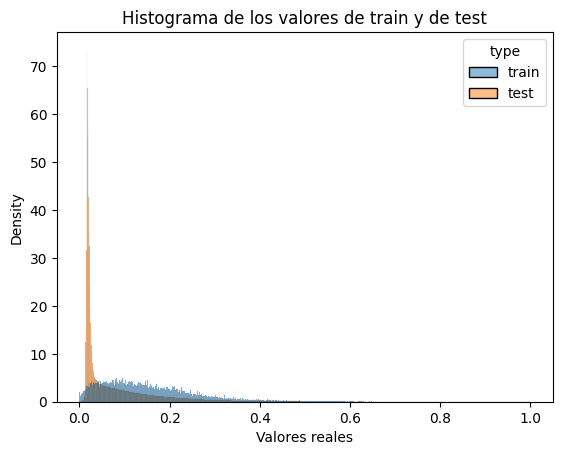

In [8]:
df1 = pd.DataFrame({'x': train_x, 'type': ['train' for _ in range(len(train_x))]})
df2 = pd.DataFrame({'x': df_1[df_1.type == 'G']['x'], 'type': ['test' for _ in range(len(df_1[df_1.type == 'G']))]})

df = pd.concat([df1, df2], axis=0)

plt.figure()
sns.histplot(data=df, x='x', hue='type', stat='density', common_norm=False)
plt.title('Histograma de los valores de train y de test')
plt.xlabel('Valores reales')
plt.show()

<Axes: xlabel='x', ylabel='Density'>

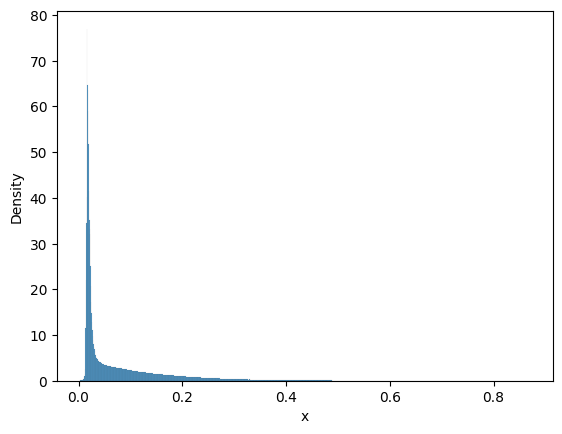

In [12]:
sns.histplot(data=df_1[df_1.type == 'G']['x'], stat='density')